<a href="https://colab.research.google.com/github/1y33/Deep-Learning/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn

import os
if not os.path.exists('dataset1'):
  !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
  !unzip -q dataset1.zip
  !rm dataset1.zip
  !pip install -q torch_snippets pytorch_model_summary

from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split

device="cuda" if torch.cuda.is_available() else "cpu"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 101.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 90.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 117.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 104.8 MB/s 

In [3]:
tfms= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [4]:
class SegData(Dataset):
  def __init__(self,split):
    self.items=stems(f'dataset1/images_prepped_{split}')
    self.split=split
  def __len__(self):
    return len(self.items)

  def __getitem__(self,ix):
    image = read(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
    image = cv2.resize(image, (224,224))
    mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png')
    mask = cv2.resize(mask, (224,224))
    return image, mask

  def choose(self):
    return self[randint(len(self))]

  def collate_fn(self,batch):
    ims,masks=list(zip(*batch))
    ims=torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
    ce_masks=torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)

    return ims,ce_masks


In [5]:
trn_ds=SegData('train')
val_ds=SegData('test')

trn_dl=DataLoader(trn_ds,batch_size=4,shuffle=True,collate_fn=trn_ds.collate_fn)
val_dl=DataLoader(val_ds,batch_size=4,shuffle=True,collate_fn=val_ds.collate_fn)

In [6]:
def conv(in_channels,out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
  )

def up_conv(in_channels,out_channels):
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size=2,stride=2),
      nn.ReLU(inplace=True)
  )

In [7]:
from torchvision.models import vgg16_bn
weights=torchvision.models.VGG16_BN_Weights.DEFAULT

class UNet(nn.Module):
  def __init__(self,weights=weights,out_channels=12):
    super().__init__()
    self.encoder=vgg16_bn(weights=weights).features
    self.block1 = nn.Sequential(*self.encoder[:6])
    self.block2 = nn.Sequential(*self.encoder[6:13])
    self.block3 = nn.Sequential(*self.encoder[13:20])
    self.block4 = nn.Sequential(*self.encoder[20:27])
    self.block5 = nn.Sequential(*self.encoder[27:34])

    self.bottleneck=nn.Sequential(*self.encoder[34:])
    self.conv_bottleneck=conv(512,1024)

    self.up_conv6=up_conv(1024,512)
    self.conv6=conv(512+512,512)
    self.up_conv7=up_conv(512,256)
    self.conv7=conv(256+512,256)
    self.up_conv8=up_conv(256,128)
    self.conv8=conv(128+256,128)
    self.up_conv9=up_conv(128,64)
    self.conv9=conv(64+128,64)
    self.up_conv10=up_conv(64,32)
    self.conv10=conv(32+64,32)
    self.conv11=nn.Conv2d(32,out_channels,kernel_size=1)

  def forward(self,x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)
    bottleneck = self.bottleneck(block5)

    x = self.conv_bottleneck(bottleneck)
    x = self.up_conv6(x)
    x = torch.cat([x, block5], dim=1)
    x = self.conv6(x)
    x = self.up_conv7(x)
    x = torch.cat([x, block4], dim=1)
    x = self.conv7(x)
    x = self.up_conv8(x)
    x = torch.cat([x, block3], dim=1)
    x = self.conv8(x)
    x = self.up_conv9(x)
    x = torch.cat([x, block2], dim=1)
    x = self.conv9(x)
    x = self.up_conv10(x)
    x = torch.cat([x, block1], dim=1)

    x=self.conv10(x)
    x=self.conv11(x)

    return x



In [8]:
ce=nn.CrossEntropyLoss()

def UNetLoss(preds,targets):
  ce_loss=ce(preds,targets)
  acc=(torch.max(preds,1)[1]==targets).float().mean()
  return ce_loss,acc

In [9]:
def train_batch(model,data,optimizer,criterion):
  model.train()
  ims,ce_masks=data
  _masks=model(ims)
  optimizer.zero_grad()
  loss,acc=criterion(_masks,ce_masks)
  loss.backward()
  optimizer.step()

  return loss.item(),acc.item()

def valid_batch(model,data,criterion):
  model.eval()
  ims,masks=data
  _masks=model(ims)
  loss,acc=criterion(_masks,masks)

  return loss.item(),acc.item()

In [11]:
model=UNet().to(device)
criterion=UNetLoss
optimizer=optim.Adam(model.parameters(),lr=1e-3)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:07<00:00, 77.7MB/s]


EPOCH: 1.000  trn_acc: 0.747  val_loss: 0.870  val_acc: 0.802  trn_loss: 1.182  (25.39s - 482.39s remaining)
EPOCH: 2.000  trn_acc: 0.829  val_loss: 0.763  val_acc: 0.795  trn_loss: 0.684  (43.61s - 392.53s remaining)
EPOCH: 3.000  trn_acc: 0.849  val_loss: 0.657  val_acc: 0.833  trn_loss: 0.567  (61.22s - 346.91s remaining)
EPOCH: 4.000  trn_acc: 0.861  val_loss: 0.571  val_acc: 0.847  trn_loss: 0.514  (79.63s - 318.50s remaining)
EPOCH: 5.000  trn_acc: 0.872  val_loss: 0.532  val_acc: 0.844  trn_loss: 0.469  (97.29s - 291.86s remaining)
EPOCH: 6.000  trn_acc: 0.871  val_loss: 0.498  val_acc: 0.864  trn_loss: 0.464  (114.93s - 268.16s remaining)
EPOCH: 7.000  trn_acc: 0.870  val_loss: 0.461  val_acc: 0.866  trn_loss: 0.460  (132.84s - 246.71s remaining)
EPOCH: 8.000  trn_acc: 0.887  val_loss: 0.466  val_acc: 0.858  trn_loss: 0.401  (150.88s - 226.32s remaining)
EPOCH: 9.000  trn_acc: 0.893  val_loss: 0.413  val_acc: 0.877  trn_loss: 0.374  (169.09s - 206.67s remaining)
EPOCH: 10.000  

100%|██████████| 121/121 [00:00<00:00, 2308.53it/s]


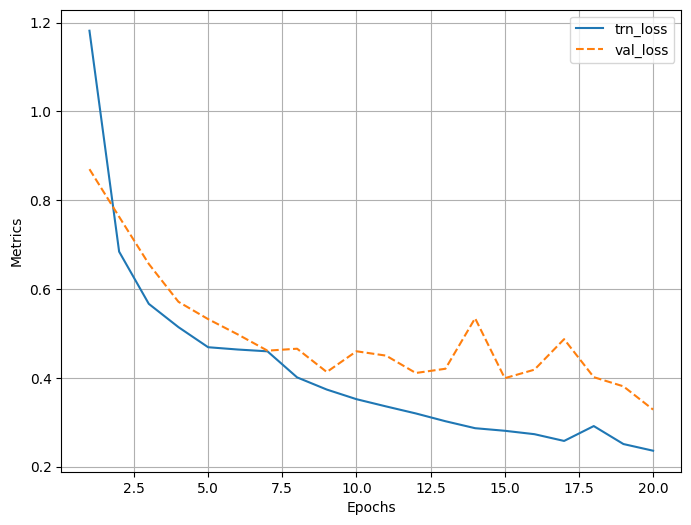

In [12]:
n_epochs=20

log=Report(n_epochs)

for epoch in range(n_epochs):
  N=len(trn_dl)
  for bx,data in enumerate(trn_dl):
    loss,acc=train_batch(model,data,optimizer,criterion)
    log.record(epoch+(bx+1)/N,trn_loss=loss,trn_acc=acc,end='\r')

  N=len(val_dl)
  with torch.inference_mode():
    for bx,data in enumerate(val_dl):
      loss,acc=valid_batch(model,data,criterion)
      log.record(epoch+(bx+1)/N,val_loss=loss,val_acc=acc,end='\r')

  log.report_avgs(epoch+1)

log.plot_epochs(['trn_loss','val_loss'])

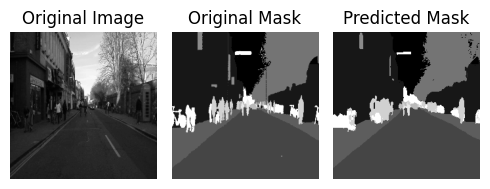

In [23]:
im,mask = next(iter(trn_dl))
_mask=model(im)
_,_mask=torch.max(_mask,dim=1)

subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0],
          mask.permute(1,2,0).detach().cpu()[:,:,0],
          _mask.permute(1,2,0).detach().cpu()[:,:,0]],nc=3,titles=['Original Image','Original Mask','Predicted Mask'])

100%|██████████| 121/121 [00:00<00:00, 505.83it/s]


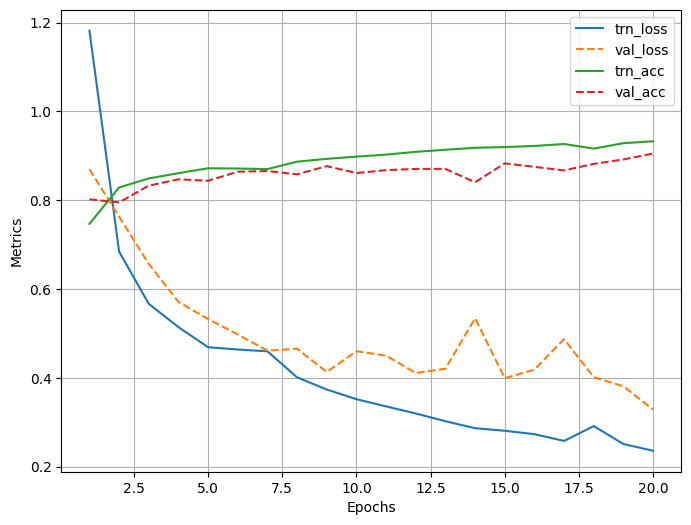

In [24]:
log.plot_epochs(['trn_loss','val_loss','trn_acc','val_acc'])